# 독립 표본 T-검정(이표본 검정, Independent two sample T-test)

서로 다른 두개의 그룹 간 평균의 차이가 유의미한지 여부를 판단한다.

데이터의 정규성과 등분산성을 만족해야 신뢰할 수 있는 결과를 얻을 수 있다.

## #01. 준비작업

### [1] 패키지 참조

`statannotations` 패키지가 필요하다

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import sys
import seaborn as sb
from math import sqrt
from pandas import read_excel, melt
from matplotlib import pyplot as plt
from scipy.stats import t, normaltest, bartlett, levene, ttest_ind
from statannotations.Annotator import Annotator

### [2] 그래프 초기화

In [2]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 9
plt.rcParams["figure.figsize"] = (15, 6)
plt.rcParams["axes.unicode_minus"] = False

## #02. 예제(1) - 지혈제 효과 비교

### [1] 데이터 가져오기

두 종료의 지혈제 효과를 측정한 자료이다.

실험 참가자를 두 그룹으로 임의 분할한 후 피부에 작은 상처를 내어 피가 흐르게 한 다음, 한 그룹에는 지혈제 B를 다른 그룹에는 지혈제 G를 투여하여 완전히 지혈될 때 까지의 시간(분)을 측정하였다.

지혈제에 따른 지혈시간이 유의미한 차이가 있는지 확인하라.

단, 모든 데이터는 정규성을 충족한다고 가정한다.

In [28]:
origin = read_excel("https://data.hossam.kr/mldata/styptic.xlsx")
origin


,B,G
0,8.80,9.9
1,8.90,10.0
2,8.40,9.0
3,7.90,11.1
4,8.20,9.8
5,8.70,9.6
6,7.90,10.3
7,9.10,8.7
8,9.60,10.4
9,8.75,9.5


### [2] 신뢰구간 확인

두 그룹의 데이터 분포와 신뢰구간을 확인한다.

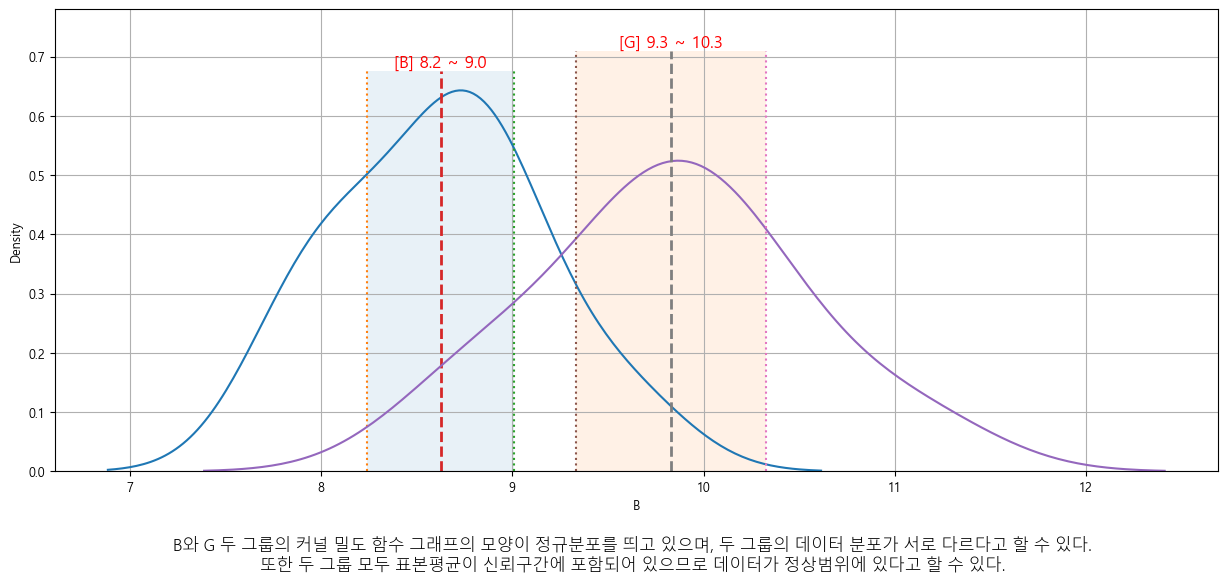

In [4]:
plt.figure()

for c in origin.columns:
    #print(c)
    
    data = origin[c]                                # 데이터만 추출
    max = data.max()                                # 최대값
    clevel = 0.95                                   # 신뢰수준
    dof = len(data) - 1                             # 자유도
    sample_mean = data.mean()                       # 표본평균
    sample_std = data.std(ddof=1)                   # 표본표준편차
    sample_std_error = sample_std / sqrt(len(data)) # 표본표준오차
    
    # 신뢰구간
    cmin, cmax = t.interval(clevel, dof, loc=sample_mean, scale=sample_std_error)

    sb.kdeplot(data=data)

    xmin, xmax, ymin, ymax = plt.axis()
    # 신뢰구간 그리기
    plt.plot([cmin, cmin], [0, ymax], linestyle=':')
    plt.plot([cmax, cmax], [0, ymax], linestyle=':')
    plt.fill_between([cmin, cmax], y1=0, y2=ymax, alpha=0.1)

    # 평균 그리기
    plt.plot([sample_mean, sample_mean], [0, ymax], linestyle='--', linewidth=2)

    plt.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 12, "color": "red"})
    
plt.ylim(0, ymax*1.1)

txt = """B와 G 두 그룹의 커널 밀도 함수 그래프의 모양이 정규분포를 띄고 있으며, 두 그룹의 데이터 분포가 서로 다르다고 할 수 있다.
또한 두 그룹 모두 표본평균이 신뢰구간에 포함되어 있으므로 데이터가 정상범위에 있다고 할 수 있다."""

plt.figtext(0.51, 0, txt, wrap=True,
            verticalalignment="top", horizontalalignment="center",
            fontdict={"size": 12, "weight": "light"})

plt.grid()
plt.show()
plt.close()

### [3] 가설검정의 가정 확인

#### (1) 정규성

In [5]:
for c in origin.columns:
    s, p = normaltest(origin[c])
    print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(c, s, p, p > 0.05))

[B] statistic: 0.083, p-value: 0.959, 정규성 충족 여부: True
[G] statistic: 0.201, p-value: 0.904, 정규성 충족 여부: True


#### (2) 등분산성

In [6]:
normal_dist = True      # 정규성 만족 여부
data = origin.copy()    # 원본 데이터 복사
fields = list(map(lambda x: data[x], data.columns))

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*fields)
else:
    n = "Levene"
    s, p = levene(*fields)
    
print("{0} 검정: statistic: {1:.3f}, p-value: {2:.3f}, 등분산성 충족 여부: {3}".format(n, s, p, p > 0.05))

Bartlett 검정: statistic: 0.556, p-value: 0.456, 등분산성 충족 여부: True


> 정규성과 등분산성을 충족하므로 가즈아~!!!

### [4] 두 그룹간 지혈 시간 평균에 차이가 있는지 검정

| 구분 | 수식 | 내용 |
|---|---|---|
| B 그룹의 평균 | $\mu(B)$ | |
| G 그룹의 평균 | $\mu(G)$ | |
| 귀무가설($H_0$) | $\mu(B) = \mu(G)$ | 두 그룹의 지혈 시간 평균은 차이가 없다. |
| 대립가설($H_1$) | $\mu(B) \neq \mu(G)$ | 두 그룹의 지혈 시간 평균은 차이가 있다. |

두 그룹간의 평균을 비교하기 위해서는 `alternative` `ttest_ind` 메서드를 사용한다.

`alternative` 파라미터에 따라 비교 내용이 달라진다.

내용은 대립가설에 따라 결정된다.

| 값 | 설명 |
|---|---|
| `two-sided` | 두 그룹의 평균이 같은지를 판단한다(기본값) |
| `greater` | 두 그룹중 첫 번째 그룹의 평균이 더 큰지 판단한다. |
| `less` | 두 그룹중 첫 번째 그룹의 평균이 더 작은지 판단한다. |

In [7]:
s, p = ttest_ind(origin['B'], origin['G'])
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: -4.350, p-value: 0.000, 대립가설 채택'

> `p-value`가 0.05보다 작으므로($p < 0.05$) 지혈제 B를 사용한 그룹과 지혈제 G를 사용한 그룹간 평균 지혈시간에는 차이가 있다.

### [5] `B`그룹의 평균이 `G`그룹 평균보다 더 큰지 검정

| 구분 | 수식 | 내용 |
|---|---|---|
| 귀무가설($H_0$) | $\mu(B) \leqq \mu(G)$ | 지혈제 B를 사용한 그룹의 평균 지혈시간은 G를 사용한 그룹의 평균 지혈시간보다 크지 않다. |
| 대립가설($H_1$) | $\mu(B) > \mu(G)$ | 지혈제 B를 사용한 그룹의 평균 지혈시간은 G를 사용한 그룹의 평균 지혈시간보다 크다. |

In [8]:
s, p = ttest_ind(origin['B'], origin['G'], alternative='greater')
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: -4.350, p-value: 1.000, 귀무가설 채택'

> `p-value`가 `0.05`보다 크므로($P \geq 0.05$) 지혈제 B를 사용한 그룹의 평균 지혈 시간은 지혈제 G를 사용한 그룹의 평균 지혈시간보다 크지 않다는 귀무가설을 기각할 수 없다.

### [6] `B`그룹의 평균이 `G`그룹 평균보다 더 작은지 검정

| 구분 | 수식 | 내용 |
|---|---|---|
| 귀무가설($H_0$) | $\mu(B) \geqq \mu(G)$ | 지혈제 B를 사용한 그룹의 평균 지혈시간은 G를 사용한 그룹의 평균 지혈시간보다 작지 않다. |
| 대립가설($H_1$) | $\mu(B) < \mu(G)$ | 지혈제 B를 사용한 그룹의 평균 지혈시간은 G를 사용한 그룹의 평균 지혈시간보다 작다. |

In [9]:
s, p = ttest_ind(origin['B'], origin['G'], alternative='less')
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: -4.350, p-value: 0.000, 대립가설 채택'

> `p-value`가 0.05보다 작으므로($P < 0.05$) 귀무가설을 기각하고 대립가설을 채택한다.
>
> 즉, 지혈제 B를 사용한 그룹의 평균 지혈 시간은 지혈제 G를 사용한 그룹의 평균 지혈시간 작다.

### [6] 가설검정 시각화

`statannotations` 패키지의 `Annotator` 함수는 `seaborn`으로 구현한 그래프에 설명을 추가하는 기능을 제공한다.

가설검정에 대해서는 영가설(귀무가설)이 $\mu(B) = \mu(G)$ 인 경우만 지원되고 작다, 크다에 대한 경우는 제공되지 않는다.

#### (1) 데이터 전처리

`hue` 파라미터를 적용할 수 있는 형태로 데이터 재배치가 필요하다.

In [10]:
df = melt(origin, var_name='group', value_name='value')
df

,group,value
0,B,8.80
1,B,8.90
2,B,8.40
3,B,7.90
4,B,8.20
5,B,8.70
6,B,7.90
7,B,9.10
8,B,9.60
9,B,8.75


#### (2) 시각화 구현

| 파라미터 | 설명 |
|---|---|
| ax | boxplot 객체 |
| data | 데이터프레임 |
| x | 명목형 변수 |
| y | 연속형 변수 |
| pairs | 비교 대상을 묶은 리스트 |
| test | 가설검정 알고리즘 종류 (`t-test_ind`, `t-test_paired`, `t-test_welch`, `Mann-Whitney`, `Mann-Whitney-gt`, `Mann-Whitney-ls`, `Levene`, `Wilcoxon`, `Kruskal` 등을 지원함) |
| text_format | 출력 형식 (`full`, `simple`, `star`)를 지원함 |

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

B vs. G: t-test independent samples, P_val:3.862e-04 t=-4.350e+00


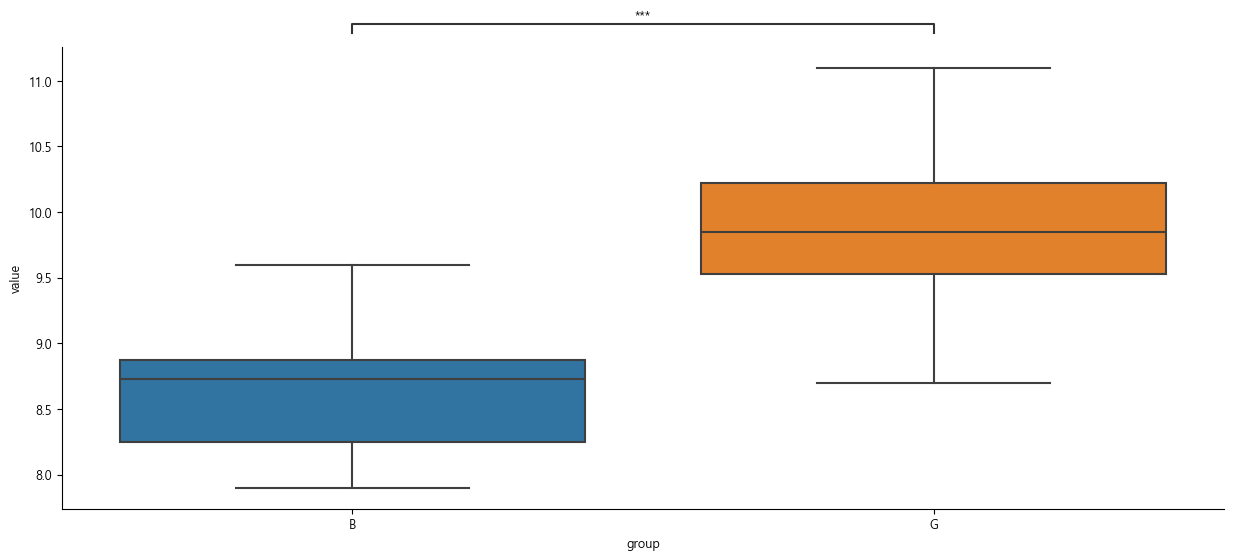

In [24]:
plt.figure()
ax = sb.boxplot(data=df, x='group', y='value')

annotator = Annotator(ax, data=df, x='group', y='value', pairs=[('B', 'G')])
annotator.configure(test='t-test_ind', text_format='star', loc='outside')
#  text_format = 'star', 'simple'
annotator.apply_and_annotate()

sb.despine()
plt.show()
plt.close()


## #03. 예제(2) - 인공심장 효과 측정

자료는 두 독립적인 그룹의 심장병 환자에 대한 심장계수(cardiac index)를 측정한 것이다.

`그룹1`은 심장수술을 받고 부착한 인공장기의 기능이 정상적인 사람들이고,

`그룹2`는 비정상으로 판명된 사람들이다.

심장계수는 수술 직후에 측정하였다.

이 두 그룹의 환자에게 부착한 인공장기의 기능에 따라 심장계수가 서로 차이가 나는지 알고 싶은 것이 이 실험의 목적이다.

단, 모든 데이터는 정규성을 충족한다고 가정한다.

### [1] 데이터 가져오기

In [31]:
origin = read_excel("https://data.hossam.kr/mldata/heatrate.xlsx")
origin

,그룹1,그룹2
0,3.84,3.97
1,2.60,2.50
2,1.19,2.70
3,2.00,3.36
4,6.20,3.55
5,0.96,2.97
6,5.50,3.20
7,3.18,2.30


### [2] 신뢰구간 확인

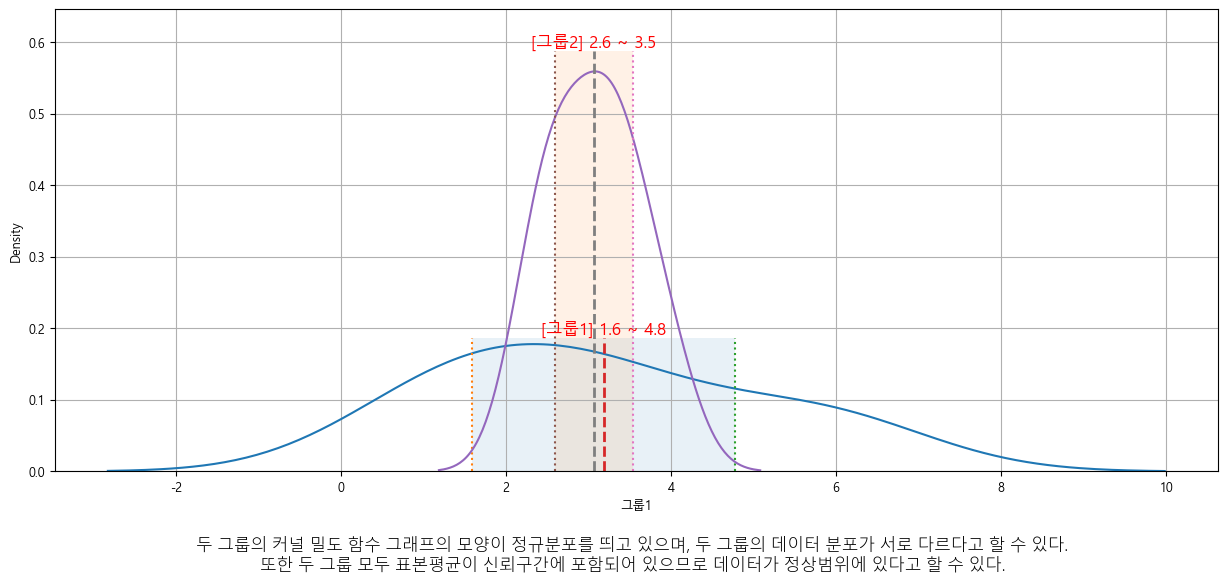

In [32]:
plt.figure()

for c in origin.columns:
    #print(c)
    
    data = origin[c]                                # 데이터만 추출
    max = data.max()                                # 최대값
    clevel = 0.95                                   # 신뢰수준
    dof = len(data) - 1                             # 자유도
    sample_mean = data.mean()                       # 표본평균
    sample_std = data.std(ddof=1)                   # 표본표준편차
    sample_std_error = sample_std / sqrt(len(data)) # 표본표준오차
    
    # 신뢰구간
    cmin, cmax = t.interval(clevel, dof, loc=sample_mean, scale=sample_std_error)

    sb.kdeplot(data=data)

    xmin, xmax, ymin, ymax = plt.axis()

    # 신뢰구간 그리기
    plt.plot([cmin, cmin], [0, ymax], linestyle=':')
    plt.plot([cmax, cmax], [0, ymax], linestyle=':')
    plt.fill_between([cmin, cmax], y1=0, y2=ymax, alpha=0.1)

    # 평균 그리기
    plt.plot([sample_mean, sample_mean], [0, ymax], linestyle='--', linewidth=2)

    plt.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 12, "color": "red"})

txt = """두 그룹의 커널 밀도 함수 그래프의 모양이 정규분포를 띄고 있으며, 두 그룹의 데이터 분포가 서로 다르다고 할 수 있다.
또한 두 그룹 모두 표본평균이 신뢰구간에 포함되어 있으므로 데이터가 정상범위에 있다고 할 수 있다."""

plt.figtext(0.51, 0, txt, wrap=True,
            verticalalignment="top", horizontalalignment="center",
            fontdict={"size": 12, "weight": "light"})

plt.ylim(0, ymax*1.1)
plt.grid()
plt.show()
plt.close()

### [3] 가설검정의 가정 확인

#### (1) 정규성

In [33]:
for c in origin.columns:
    s, p = normaltest(origin[c])
    print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(c, s, p, p > 0.05))

[그룹1] statistic: 0.840, p-value: 0.657, 정규성 충족 여부: True
[그룹2] statistic: 0.261, p-value: 0.878, 정규성 충족 여부: True


#### (2) 등분산성

In [34]:
normal_dist = True      # 정규성 만족 여부
data = origin.copy()    # 원본 데이터 복사
fields = list(map(lambda x: data[x], data.columns))

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*fields)
else:
    n = "Levene"
    s, p = levene(*fields)
    
print("{0} 검정: statistic: {1:.3f}, p-value: {2:.3f}, 등분산성 충족 여부: {3}".format(n, s, p, p > 0.05))

Bartlett 검정: statistic: 8.029, p-value: 0.005, 등분산성 충족 여부: False


> 정규성은 만족하지만 등분산성을 만족하지는 않는다. 어떻게 하지?

### [4] 두 그룹간 심장계수의 차이가 있는지를 검정

데이터의 등분산성이 만족되지 않을 경우 `Welch's T-test`를 수행하기 위해 `equal_var` 파라미터에 `False`를 설정한다. (기본값=`True`)

| 구분 | 수식 | 내용 |
|---|---|---|
| 그룹1의 평균 | $\mu(1)$ | |
| 그룹2의 평균 | $\mu(2)$ | |
| 귀무가설($H_0$) | $\mu(1) = \mu(2)$ | 두 그룹의 심장계수 평균은 차이가 없다. |
| 대립가설($H_1$) | $\mu(1) \neq \mu(2)$ | 두 그룹의 심장계수 평균은 차이가 있다. |

In [35]:
s, p = ttest_ind(origin['그룹1'], origin['그룹2'], alternative='two-sided', equal_var=False)
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 0.163, p-value: 0.874, 귀무가설 채택'

> `p-value`가 `0.05`보다 크므로($P > 0.05$) 귀무가설을 기각할 수 없다. 즉, 두 그룹의 심장계수가 다르다고 판단할 근거가 없다.

### [5] 그룹1의 심장계수가 그룹2의 심장계수보다 작은지 검정


| 구분 | 수식 | 내용 |
|---|---|---|
| 귀무가설($H_0$) | $\mu(1) \geqq \mu(2)$ | 그룹1의 심장계수는 그룹2의 심장계수보다 작지 않다. |
| 대립가설($H_1$) | $\mu(1) \lt \mu(2)$ | 그룹1의 심장계수는 그룹2의 심장계수보다 작다. |

In [36]:
s, t = ttest_ind(origin['그룹1'], origin['그룹2'], alternative='less', equal_var=False)
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 0.163, p-value: 0.874, 귀무가설 채택'

> `p-value`가 `0.05`보다 크므로($P > 0.05$) 귀무가설을 기각할 수 없다. 즉, 그룹1의 심장계수는 그룹2의 심장계수보다 작지 않다.

### [6] 그룹1의 심장계수가 그룹2의 심장계수보다 큰지 검정


| 구분 | 수식 | 내용 |
|---|---|---|
| 귀무가설($H_0$) | $\mu(1) \leqq \mu(2)$ | 그룹1의 심장계수는 그룹2의 심장계수보다 크지 않다. |
| 대립가설($H_1$) | $\mu(1) \gt \mu(2)$ | 그룹1의 심장계수는 그룹2의 심장계수보다 크다. |

In [37]:
s, t = ttest_ind(origin['그룹1'], origin['그룹2'], alternative='greater', equal_var=False)
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 0.163, p-value: 0.874, 귀무가설 채택'

> `p-value`가 `0.05`보다 크므로($P > 0.05$) 귀무가설을 기각할 수 없다. 즉, 그룹1의 심장계수가 그룹2의 심장계수보다 크지 않다.

### [7] 가설검정 시각화

`statannotations` 라이브러리는 `Welch's T-Test`를 직접 지원하기 때문에 시각화 코드에서 추가적으로 처리해야 할 부분은 없다.

In [38]:
df = melt(origin, var_name='group', value_name='value')
df

,group,value
0,그룹1,3.84
1,그룹1,2.60
2,그룹1,1.19
3,그룹1,2.00
4,그룹1,6.20
5,그룹1,0.96
6,그룹1,5.50
7,그룹1,3.18
8,그룹2,3.97
9,그룹2,2.50


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

그룹1 vs. 그룹2: t-test independent samples, P_val:8.726e-01 t=1.633e-01


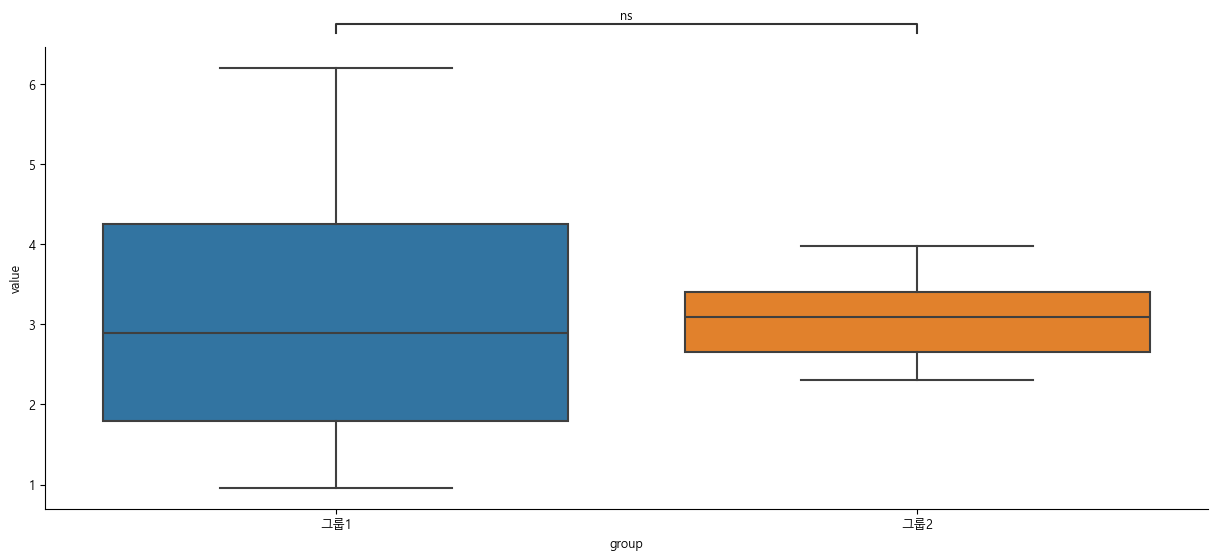

In [44]:
config = {
    "data": df,
    "x": "group",
    "y": "value",
    "pairs": [("그룹1", "그룹2")],
    "test": "t-test_ind",
    "text_format": "star",
    "loc": "outside"
}

plt.figure()
ax = sb.boxplot(data=config['data'], x=config['x'], y=config['y'])
ax.get_xaxis().axis_name

annotator = Annotator(ax, data=config['data'], x=config['x'], y=config['y'], pairs=config['pairs'])
annotator.configure(test=config['test'], text_format=config['text_format'], loc=config['loc'])
annotator.apply_and_annotate()

sb.despine()
plt.show()
plt.close()